In [1]:
!pip3 install vaderSentiment
!pip3 install torch
!pip3 install transformers
!pip3 install torch-transformer

     |████████████████████████████████| 133kB 6.6MB/s 
     |████████████████████████████████| 1.3MB 7.2MB/s 
     |████████████████████████████████| 890kB 51.6MB/s 
     |████████████████████████████████| 1.1MB 48.3MB/s 
     |████████████████████████████████| 2.9MB 51.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=ab3d0563dabf036d6557611db7294d4d9fda20904efce308f0deb6d357930aff
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
  Created wheel for torch-transformer: filename=torch_transformer-0.18.1-cp36-none-any.whl size=7767 sha256=df32201453a1feaa53e7d6c6d6b6c0a5472802456104ff1ddaaffa5083149193
  Stored in directory: /root/.cache/pip/wheels/a4/31/69/c689f0af2941d78d71fb61b09d2bb7ef80a3b7652f1c14a2c1
  Created wheel for torch-position-embedding: filename=torch_position_embedding-0.7.1-cp36-none-any.whl size=4506 sha256=986b8d063bb463c8dfeb1d0

In [2]:
import gc
import numpy as np
import pandas as pd
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline,FeatureUnion
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.metrics import plot_roc_curve
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor,AdaBoostRegressor,BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from nltk.cluster import KMeansClusterer,cosine_distance, euclidean_distance
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [3]:
gc.set_threshold(20,5,5)
gc.collect()

0

In [4]:
product_reviews_ratings=pd.read_csv('/content/drive/My Drive/amazon_reviews_project/pre_processed_data.csv')

In [5]:
product_reviews_ratings.head(2)

,asin,overall,verified,reviewText,reviewTime
0,0007444117,1,False,I was a huge fan when the Divergent series sta...,2016-09-03
1,0007177437,4,True,Excellent read.,2015-09-16


In [6]:
product_reviews_ratings['asin'].value_counts()

038568231X    8736
0312577222    7092
1683247353    4745
0553418025    4726
1503943372    4522
              ... 
1479700630       1
1684091470       1
B000K19G72       1
1257646826       1
1580174264       1
Name: asin, Length: 975727, dtype: int64

In [7]:
#Let's create a list of 5 most reviewed books from this list
product_list=product_reviews_ratings['asin'].value_counts().index[:5]
product_list

Index(['038568231X', '0312577222', '1683247353', '0553418025', '1503943372'], dtype='object')

In [9]:
#Let's create a function that includes a neural net to classify reviews for any given books
def custom_model(input_dataframe,review_column_name,rating_column_name,output_filename):
  #import necessary libraries
  import sys
  import gc
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt

  from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

  import tensorflow as tf
  from tensorflow import keras
  from tensorflow.keras.models import Sequential
  from tensorflow.keras import layers
  from keras.regularizers import l2
  from keras.layers import Dropout
  from keras.preprocessing.text import Tokenizer
  from keras.preprocessing.sequence import pad_sequences
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.callbacks import EarlyStopping,CSVLogger

  import torch
  import transformers as ppb # pytorch transformers

  #check memory usage (Location 1)
  #memory_usage_by_variable=pd.DataFrame({k:sys.getsizeof(v) for (k,v) in locals().items()},index=['Size'])
  #memory_usage_by_variable=memory_usage_by_variable.T
  #memory_usage_by_variable.sort_values(by='Size',ascending=False,inplace=True)
  #print('Location_1:\n ',memory_usage_by_variable)

  gc.set_threshold(10,5,5)

  review_column_name=str(review_column_name)
  rating_column_name=str(rating_column_name)
  reviews_ratings_selection=input_dataframe[:6000]

  #trigger garbage collection
  #del input_dataframe
  #gc.collect()

  text_data=reviews_ratings_selection[review_column_name].astype('str')

  #set parameters
  max_len=512
  training_samples=3000
  validation_samples=517
  max_words=1_500

  #classes from pytorch distillbert
  model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')


  #instantiate instance of Vader sentiment analyzer
  sentiment=SentimentIntensityAnalyzer()
  #using vader sentiment analyzer for a second input
  df=pd.DataFrame(text_data)
  df_polarity=pd.DataFrame([sentiment.polarity_scores(df.loc[:,'reviewText'][i][-300:]) for i in df.index])
  df_polarity_input=df_polarity.iloc[:,:3] #de-selecting combined score

  #instantiate tokenizer and model class from pytorch
  tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
  model = model_class.from_pretrained(pretrained_weights)

  #dataframe with text extract from the reviews
  df_to_tokenize=pd.DataFrame([df.loc[:,'reviewText'][i][:max_len] for i in df.index])
  tokenized = df_to_tokenize[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
  
  #padding to give us the ability to process strings of unequal length
  max_len = 0
  for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)

  padded_data = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
  attention_mask = np.where(padded_data != 0, 1, 0)
  input_ids = torch.tensor(padded_data)  
  attention_mask = torch.tensor(attention_mask)

  #trigger garbage collection
  del reviews_ratings_selection
  del tokenized
  del df
  del df_to_tokenize
  gc.collect()

  #check memory usage (Location 2)
  #memory_usage_by_variable=pd.DataFrame({k:sys.getsizeof(v) for (k,v) in locals().items()},index=['Size'])
  #memory_usage_by_variable=memory_usage_by_variable.T
  #memory_usage_by_variable.sort_values(by='Size',ascending=False,inplace=True)
  #print('Location_2:\n ',memory_usage_by_variable)

  with torch.no_grad():
      last_hidden_states = model(input_ids, attention_mask)
  
  data = last_hidden_states[0][:,0,:].numpy()
  ss=StandardScaler()
  data=ss.fit_transform(data)
  
  #re-define reviews_ratings_selection. I deleted this earlier to save space.
  reviews_ratings_selection=input_dataframe[:6000]

  #y is rating (here referred to as 'overall')
  y=reviews_ratings_selection['overall']
  #let's reset index of y
  y=y.reset_index()['overall']
  #Since we are converting only 2 of 5 possible ratings we need to offset the ratings by 3
  y=y-3
  y_categorical=tf.keras.utils.to_categorical(y)

  #delete reviews_ratings_selection and trigger garbage collection
  del reviews_ratings_selection
  gc.collect()

  #create train/test sets
  X_train=data[:training_samples]
  df_polarity_train=df_polarity_input[:training_samples]
  X_test=data[training_samples:training_samples+validation_samples]
  df_polarity_test=df_polarity_input[training_samples:training_samples+validation_samples]

  #y_train=y[:training_samples]
  y_train_categorical=y_categorical[:training_samples]  #no need to encode since we have only two classes
  #y_test=y[training_samples:training_samples+validation_samples]
  y_test_categorical=y_categorical[training_samples:training_samples+validation_samples]  #no need to encode since we have only two classes

  #Ratings 1,2,3,4,5 to correspond to labels 0,1,2,3,4 respectively.

  ##Neural-Network
  input_A = keras.layers.Input(shape=(768,1))
  input_B = keras.layers.Input(shape=(3, ))
  batch_normalization=keras.layers.BatchNormalization()(input_A)
  hidden0=keras.layers.LSTM(units=768, input_shape=(768,1))(batch_normalization)
  hidden1=keras.layers.Dense(1024,activation='relu',kernel_regularizer=l2(0))(hidden0)
  hidden2=keras.layers.Dense(512,activation='relu',kernel_regularizer=l2(0))(hidden1)
  hidden3=keras.layers.Dense(512,activation='relu',kernel_regularizer=l2(0))(hidden2)
  hidden4=keras.layers.Dense(128,activation='relu',kernel_regularizer=l2(0))(hidden3)
  hidden5=keras.layers.Dense(128,activation='relu',kernel_regularizer=l2(0))(hidden4)
  hidden6=keras.layers.Dense(64,activation='relu',kernel_regularizer=l2(0))(hidden5)
  concat=keras.layers.concatenate([hidden1,hidden2,hidden6])
  hidden7=keras.layers.Dense(128,activation='relu',kernel_regularizer=l2(0))(concat)
  hidden8=keras.layers.Dense(128,activation='relu',kernel_regularizer=l2(0))(hidden7)
  concat2=keras.layers.concatenate([hidden0,hidden8,input_B])
  batch_normalization2=keras.layers.BatchNormalization()(concat2)
  hidden9=keras.layers.Dense(256,activation='relu',kernel_regularizer=l2(0))(batch_normalization2)
  hidden10=keras.layers.Dense(128,input_shape=(25,1),activation='relu',kernel_regularizer=l2(0))(hidden9)
  flatten1=keras.layers.Flatten()(input_A)
  concat3=keras.layers.concatenate([flatten1,hidden0,hidden10])
  batch_normalization3=keras.layers.BatchNormalization()(concat3)
  hidden11=keras.layers.Dense(256,activation='relu',kernel_regularizer=l2(0))(batch_normalization3)
  hidden12=keras.layers.Dense(256,activation='relu',kernel_regularizer=l2(0))(hidden11)
  hidden13=keras.layers.Dense(256,activation='relu',kernel_regularizer=l2(0))(hidden12)
  hidden14=keras.layers.Dense(128,activation='relu',kernel_regularizer=l2(0))(hidden13)
  hidden15=keras.layers.Dense(128,activation='relu',kernel_regularizer=l2(0))(hidden14)
  output=keras.layers.Dense(2,activation='sigmoid')(hidden15)

  #define model
  model=keras.models.Model(inputs=[input_A,input_B], outputs=[output])

  #add a callback
  callback=EarlyStopping(monitor='loss',patience=5)

  #compile model
  model.compile(
      loss='categorical_crossentropy',
      optimizer=keras.optimizers.Adam(lr=0.03), #'Adadelta',  #keras.optimizers.Adam(lr=0.03),
      metrics=[keras.metrics.BinaryAccuracy()],
  )

  #plot architecture of model
  keras.utils.plot_model(model, "/content/drive/My Drive/model_file_19.png")

  #fit defined model
  history=model.fit((X_train,df_polarity_train),y_train_categorical,batch_size=32,validation_data=((X_test,df_polarity_test),y_test_categorical),callbacks=callback,epochs=6,verbose=1)
  output_filename='/content/drive/My Drive/amazon_reviews_project/'+str(output_filename)
  model.save(output_filename)

  return history

In [10]:
#Let's start testing with the most reviewed item: '0312577222'
reviews_1=product_reviews_ratings[product_reviews_ratings['asin']=='0312577222']
reviews_1.dropna(inplace=True)


#Let's choose only reviews that are rated 3 and 4 since they tend to be the most balanced.
reviews_1=reviews_1[(reviews_1['overall']==3)|(reviews_1['overall']==4)]
reviews_1.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,asin,overall,verified,reviewText,reviewTime
474964,0312577222,4,False,Not exactly my type of book. I received it for...,2017-04-27
474985,0312577222,4,True,Should be more like four and one-half stars. I...,2015-08-17


In [11]:
reviews_1['overall'].value_counts(normalize=True)

4    0.82069
3    0.17931
Name: overall, dtype: float64

In [12]:
reviews_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 870 entries, 474964 to 3978390
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   asin        870 non-null    object
 1   overall     870 non-null    int64 
 2   verified    870 non-null    bool  
 3   reviewText  870 non-null    object
 4   reviewTime  870 non-null    object
dtypes: bool(1), int64(1), object(3)
memory usage: 34.8+ KB


In [13]:
reviews_1[reviews_1['reviewText'].isnull()==True]

,asin,overall,verified,reviewText,reviewTime


There seems to be no null values present in the dataset.


In [14]:
history=custom_model(reviews_1,'reviewText','overall','model_19')


Epoch 1/6
28/28 [==============================] - 96s 3s/step - loss: 2.8224 - binary_accuracy: 0.8132
Epoch 2/6
28/28 [==============================] - 99s 4s/step - loss: 2.8901 - binary_accuracy: 0.8207
Epoch 3/6
28/28 [==============================] - 102s 4s/step - loss: 2.8901 - binary_accuracy: 0.8207
Epoch 4/6
28/28 [==============================] - 99s 4s/step - loss: 2.8901 - binary_accuracy: 0.8207
Epoch 5/6
28/28 [==============================] - 101s 4s/step - loss: 2.8901 - binary_accuracy: 0.8207
Epoch 6/6
28/28 [==============================] - 103s 4s/step - loss: 2.8901 - binary_accuracy: 0.8207
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/amazon_reviews_project/model_19/assets


NameError: ignored

KeyError: ignored

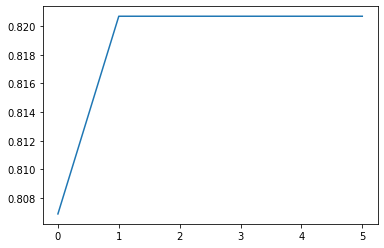

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],label='Train accuracy')   #mae on training set
plt.plot(history.history['val_accuracy'],label='Validation accuracy');  #mae on validation set
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

In [ ]:
plt.plot(history.history['loss'],label='Train Loss')   #mae on training set
plt.plot(history.history['val_loss'],label='Validation Loss');  #mae on validation set
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss');

NameError: ignored

In [ ]:
""